# Importing Packages

In [1]:
import os
import pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from sklearn.model_selection import train_test_split
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

C:\Users\we\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Data Loading and Preprocessing

In [2]:
# Set directory path
directory = 'dataset/'

# Get list of all folders in directory
class_labels = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

# Print list of folders
print(class_labels)

['Angry', 'Happy', 'Neutral', 'Sad']


In [3]:
# Set parameters
n_mfcc = 20

# Initialize lists for audio data and labels
X = []
y = []

# Loop through each class directory
for i, label in enumerate(class_labels):
    class_dir = f'dataset/{label}/'
    
    # Loop through each audio file in the class directory
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        
        try:
            # Load audio file
            audio = AudioSegment.from_file(file_path)
            audio_data = np.array(audio.get_array_of_samples())
            sample_rate = audio.frame_rate
        
            # Split audio into chunks of silence
            audio_chunks = split_on_silence(audio, min_silence_len=500, silence_thresh=-50)
            
            # Extract MFCCs from each chunk of audio
            nfft = 2400 # Set larger FFT size
            for chunk in audio_chunks:
                chunk_data = np.array(chunk.get_array_of_samples())
                mfccs = mfcc(chunk_data, samplerate=sample_rate, numcep=n_mfcc, nfft=nfft) # Set larger nfft value
                mfccs = np.mean(mfccs, axis=0)
  
                # Append MFCCs and label to lists
                X.append(mfccs)
                y.append(i)
                
        except Exception as e:
            # Skip file if it is not a recognized audio format
            print(f'Skipping file {filename}: {e}')

<AxesSubplot: xlabel='label', ylabel='count'>

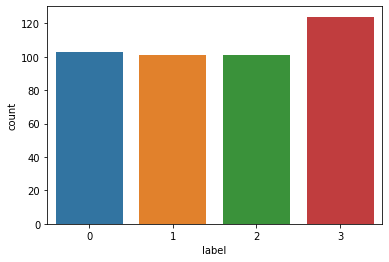

In [4]:
import seaborn as sns
y = np.array(y)

# Create DataFrame with labels
labels_df = pd.DataFrame({'label': y})

# Create count plot of labels
sns.countplot(x='label', data=labels_df)

In [5]:
# Convert labels to one-hot encoded vectors
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y.reshape(len(y), 1))

In [6]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(343, 20)

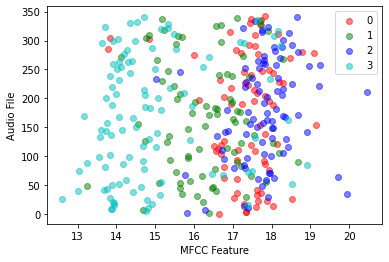

In [9]:
# Define colors for each class label
colors = ['r', 'g', 'b', 'c']

# Create scatter plot of MFCC features
fig, ax = plt.subplots()
for i, color in enumerate(colors):
    idx = np.where(y_train[:, i] == 1)[0]
    ax.scatter(X_train[idx, 0], idx, color=color, label=label_encoder.inverse_transform([i])[0], alpha=0.5)

ax.legend(loc='upper right')
ax.set_xlabel('MFCC Feature')
ax.set_ylabel('Audio File')
plt.show()

# Model Creation (MLP)

In [10]:
from sklearn.neural_network import MLPClassifier

# Train the MLP on the training data and store the loss history
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
history = mlp.fit(X_train, y_train).loss_curve_

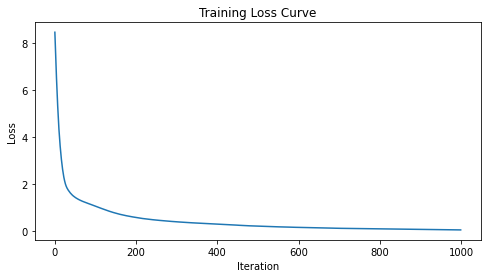

In [11]:
# Plot the loss curve
plt.figure(figsize=(8, 4))
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [14]:
# Evaluate the model on the test set
test_acc = mlp.score(X_test, y_test)
print('Test accuracy:', test_acc)

# Generate predictions on the test set
y_pred = mlp.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert predictions to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_labels))


Test accuracy: 0.9302325581395349
              precision    recall  f1-score   support

       Angry       0.93      1.00      0.97        28
       Happy       0.88      0.95      0.91        22
     Neutral       1.00      0.93      0.96        14
         Sad       1.00      0.86      0.93        22

    accuracy                           0.94        86
   macro avg       0.95      0.94      0.94        86
weighted avg       0.95      0.94      0.94        86



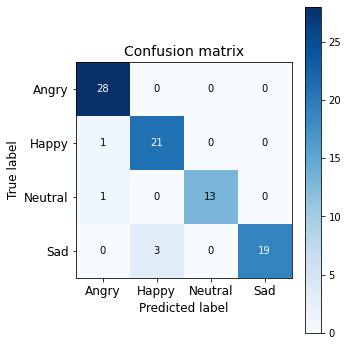

In [15]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(conf_matrix, cmap="Blues")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Add labels to the x-axis and y-axis
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=12)
ax.set_yticklabels(class_labels, fontsize=12)

# Add annotations
thresh = conf_matrix.max() / 2.0
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax.text(j, i, format(conf_matrix[i, j], "d"),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

# Add title and axis labels
ax.set_title("Confusion matrix", fontsize=14)
ax.set_xlabel("Predicted label", fontsize=12)
ax.set_ylabel("True label", fontsize=12)

plt.tight_layout()
plt.show()


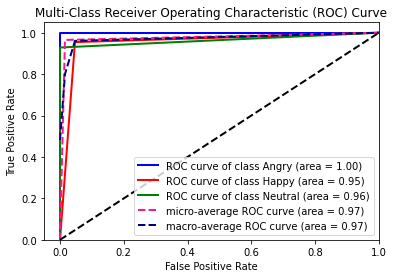

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

classes = class_labels

# Compute the predicted class probabilities for each sample
y_pred_prob = mlp.predict(X_test)

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
tpr_macro = np.zeros_like(fpr_macro)
for i in range(len(classes)):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= len(classes)
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot the ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

# Plot the micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2, linestyle='--',
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_micro))

# Plot the macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, color='navy', lw=2, linestyle='--',
         label='macro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_macro))

# Add labels and legend
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
def predict_class(audio_path):
    n_mfcc = 20
    
    # Load audio file
    audio = AudioSegment.from_file(audio_path)
    audio_data = np.array(audio.get_array_of_samples())
    sample_rate = audio.frame_rate

    # Split audio into chunks of silence
    audio_chunks = split_on_silence(audio, min_silence_len=500, silence_thresh=-50)

    # Extract MFCCs from each chunk of audio
    mfccs_list = []
    nfft = 2048 # Set larger FFT size
    for chunk in audio_chunks:
        chunk_data = np.array(chunk.get_array_of_samples())
        mfccs = mfcc(chunk_data, samplerate=sample_rate, numcep=n_mfcc, nfft=nfft) # Set larger nfft value
        mfccs = np.mean(mfccs, axis=0)
        mfccs_list.append(mfccs)

    # Convert MFCCs to a numpy array
    mfccs_array = np.array(mfccs_list)

    # Reshape MFCCs to have 1 channel
    #mfccs_array = mfccs_array.reshape(mfccs_array.shape[0], mfccs_array.shape[1], 1)

    # Get predicted probabilities for each class
    probs = mlp.predict(mfccs_array)

    # Convert probabilities to predicted class labels
    predicted_classes = np.argmax(probs, axis=1)

    # Convert predicted class labels to class names
    class_names = ['Angry', 'Happy', 'Neutral', 'Sad']
    predicted_class_names = [class_names[i] for i in predicted_classes]

    return predicted_class_names

In [20]:
predict_class('jdck.wav')

['Angry']

In [21]:
import pickle

# Save the trained MLP to a file
with open("mlp.pkl", "wb") as f:
    pickle.dump(mlp, f)